# Network Modeling with SEIRS+ Notebook 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_params import *
import pickle as pkl


Bad key "text.kerning_factor" on line 4 in
/Users/dafirebanks/miniconda3/envs/dsci/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [65]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

### 1) Load base graph for Moria or create a new one

In [66]:
# graph, nodes_per_struct = load_graph("experiments/networks/Moria_wNeighbors_4")

household_weight = 0.98
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:08<00:00, 2190.03it/s]


In [67]:
graph

In [68]:
graph, nodes_per_struct[:10], len(nodes_per_struct)

(<networkx.classes.graph.Graph at 0x7fbd3ece6390>,
 [[2167, 7020, 16414, 17224, 17735],
  [4075, 4681, 7609, 12738, 12974, 16191, 16421],
  [12910, 13338, 15443, 16597, 17401],
  [1537, 8838, 8843, 12794, 18178, 18508],
  [3280, 10200, 11320, 12540, 13098, 13269, 16899, 17412, 17994],
  [4293, 9254, 9828, 14260, 14839, 17791],
  [2243,
   3550,
   4428,
   9434,
   10252,
   11560,
   11955,
   12671,
   16408,
   17347,
   17493,
   18526],
  [4235, 4416, 7353, 8399, 9887, 11180, 15198, 15539, 18059, 18213],
  [2035, 2065, 2525, 5894, 7713, 12473, 12835, 14928, 17850],
  [56, 2666, 6344, 11277, 12648, 15902, 16853]],
 3479)

In [96]:
def num_structs(structs, num_nodes):
    """ Number of structures that contain num_nodes people """
    return sum([1 for struct in structs if len(struct) == num_nodes])

def nodes_with_degree(G, n):
    """ Number of nodes with degree n in graph G """
    return len([1 for node in G.nodes if G.degree(node) == n])

In [70]:
# Household of 1 person = degree 0 
nodes_with_degree(graph, 0), num_structs(nodes_per_struct, 1)

(58, 58)

In [71]:
# TODO: Update this in model_server
def link_nodes_by_activity(base_graph, nodes_per_struct, percentage_per_struct, proximity_radius, edge_weight,
                           activity_name):
    """ Connect a given percentage of nodes per structure that engage in the same activity
        with other nodes from different structures that engage in the same activity, at a given proximity radius
        Examples of activities:
        - Food queue
        - Religious events
    """
    graph = base_graph.copy()

    activity_bois = set()

    # Choose a percentage of people randomly from each structure
    for node_list in nodes_per_struct:
        if len(node_list) == 1:
            activity_bois.add(node_list[0])
        else:
            for i in range(int(len(node_list) * percentage_per_struct)):
                activity_bois.add(np.random.choice(node_list))

    activity_bois = list(activity_bois)
    np.random.shuffle(activity_bois)

    # Draw an edge between everyone in the list within a given proximity
    for i in range(len(activity_bois) - proximity_radius):
        for j in range(i + 1, i + proximity_radius + 1):
            if not graph.has_edge(activity_bois[i], activity_bois[j]):
                graph.add_edge(
                    activity_bois[i],
                    activity_bois[j],
                    weight=edge_weight,
                    label=activity_name)
    return graph

#### 1.1) We will add a general food queue which represents the current state of the camp

In [72]:
food_weight = 0.407
# graph_1fq = connect_food_queue(graph, nodes_per_struct, food_weight, "food")
graph_1fq = link_nodes_by_activity(graph, nodes_per_struct, percentage_per_struct=0.5, proximity_radius=5, edge_weight=food_weight, activity_name="food")

In [73]:
nodes_with_degree(graph_1fq, 0), num_structs(nodes_per_struct, 1)

(0, 58)

### 2) Plot the basic network degrees

Min degree: 0 Max degree: 14
Baseline:
Degree: mean = 5.34, std = 2.37, 95% CI = (1.00, 11.00)
        coeff var = 0.44
Assortativity:    1.00
Clustering coeff: 0.97



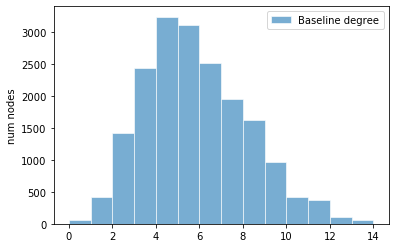

In [74]:
# Degrees without food queue, just neighbors
min_G, max_G = min_degree(graph), max_degree(graph)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph, max_degree=max_G)
network_info(graph, "Baseline", plot=True)

Min degree: 1 Max degree: 24
Baseline with 1 food queue:
Degree: mean = 9.28, std = 5.41, 95% CI = (2.00, 19.00)
        coeff var = 0.58
Assortativity:    0.29
Clustering coeff: 0.75



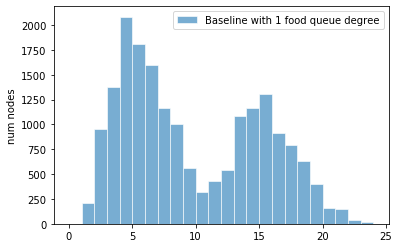

In [75]:
# Degrees with 1 food queue
min_G, max_G = min_degree(graph_1fq), max_degree(graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph_1fq, max_degree=max_G)
network_info(graph_1fq, "Baseline with 1 food queue", plot=True)

In [76]:
neighbor_weight = 0.017

graph_1fq = link_nodes_by_property(graph_1fq, 0, n_isoboxes, nodes_per_struct,
                              grid_isoboxes, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                              grid_block1, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                              grid_block2, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                              grid_block3, 2, "ethnicity", neighbor_weight, 'friendship')

Min degree: 1 Max degree: 195
Baseline with neighbours:
Degree: mean = 22.28, std = 15.22, 95% CI = (2.00, 49.00)
        coeff var = 0.68
Assortativity:    0.02
Clustering coeff: 0.41



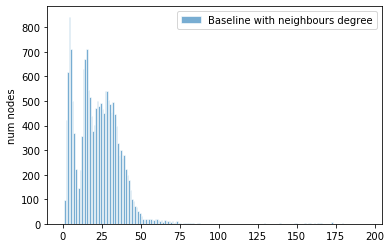

In [77]:
# Actual neighbours?
min_G, max_G = min_degree(graph_1fq), max_degree(graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph_1fq, max_degree=max_G)
network_info(graph_1fq, "Baseline with neighbours", plot=True)

In [78]:
nodes_with_degree(graph, 0), nodes_with_degree(graph, 1), nodes_with_degree(graph, 2) 

(58, 418, 1425)

In [79]:
nodes_with_degree(graph_1fq, 0), nodes_with_degree(graph_1fq, 1), nodes_with_degree(graph_1fq, 2) 

(0, 96, 422)

### 3.1 Sampling nodes from the graph

In [80]:
def update_nodes_per_struct(nodes_per_struct, relabel_map):
    new_nodes_per_struct = []
    for i, struct in enumerate(nodes_per_struct):
        sampled_nodes = []
        for j, node in enumerate(struct):
            if node in relabel_map:
                sampled_nodes.append(relabel_map[node])
        if len(sampled_nodes) != 0:
            new_nodes_per_struct.append(sampled_nodes)
    
    return new_nodes_per_struct

In [81]:
# TODO: Update this in model_server
def downsample_graph(graph, nodes_per_struct, new_graph_size, technique):
    if technique == "uniform":
        sampled_nodes = random.sample(graph.nodes, new_graph_size)
        sampled_graph = graph.subgraph(sampled_nodes)
        relabel_map = dict(zip(list(sampled_graph.nodes), range(len(sampled_graph.nodes))))
        final_graph = nx.relabel_nodes(sampled_graph, relabel_map)
        updated_nodes_per_struct = update_nodes_per_struct(nodes_per_struct, relabel_map)
        return final_graph, updated_nodes_per_struct
    else:
        return None

In [84]:
scale = 4
new_pop_size = n_pop // scale
sampled_graph, sampled_nodes_per_struct = downsample_graph(graph_1fq, nodes_per_struct, new_pop_size, "uniform")

Min degree: 0 Max degree: 52
Sampled baseline with neighbours:
Degree: mean = 5.66, std = 4.44, 95% CI = (0.00, 15.00)
        coeff var = 0.79
Assortativity:    0.01
Clustering coeff: 0.27



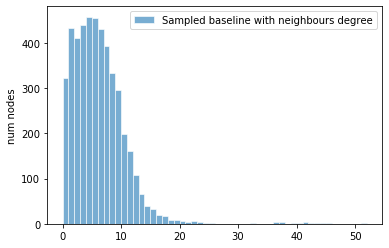

In [85]:
min_G, max_G = min_degree(sampled_graph), max_degree(sampled_graph)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph_1fq, max_degree=max_G)
network_info(sampled_graph, "Sampled baseline with neighbours", plot=True)

In [86]:
nodes_with_degree(sampled_graph, 0), nodes_with_degree(sampled_graph, 1), nodes_with_degree(sampled_graph, 2) 

(323, 434, 412)

In [87]:
num_structs(nodes_per_struct, 1), num_structs(nodes_per_struct, 2), num_structs(nodes_per_struct, 3)

(58, 209, 475)

In [89]:
num_structs(sampled_nodes_per_struct, 1), num_structs(sampled_nodes_per_struct, 2), num_structs(sampled_nodes_per_struct, 3)

(1293, 808, 366)

### 3.2 Connect sampled nodes to a food queue

In [90]:
sampled_graph_1fq = link_nodes_by_activity(sampled_graph, sampled_nodes_per_struct, percentage_per_struct=0.5, proximity_radius=5, edge_weight=food_weight, activity_name="food")

Min degree: 1 Max degree: 55
Sampled baseline with neighbours and 1 food queue:
Degree: mean = 11.49, std = 6.16, 95% CI = (1.00, 23.00)
        coeff var = 0.54
Assortativity:    0.01
Clustering coeff: 0.35



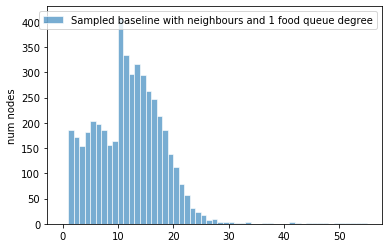

In [91]:
min_G, max_G = min_degree(sampled_graph_1fq), max_degree(sampled_graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
# plot_degree_distn(graph_1fq, max_degree=max_G)
network_info(sampled_graph_1fq, "Sampled baseline with neighbours and 1 food queue", plot=True)

### 3.3 Plot node count per structure distribution

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

In [93]:
def plot_struct_dist(nodes_per_struct):
    struct_lengths = np.array([len(struct) for struct in nodes_per_struct])
    plt.hist(struct_lengths)
    plt.show()

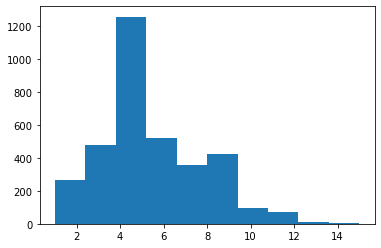

In [94]:
plot_struct_dist(nodes_per_struct)

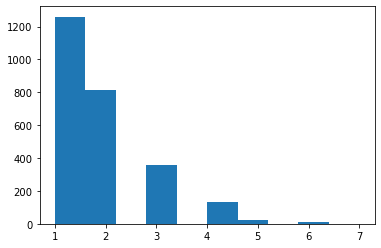

In [95]:
plot_struct_dist(updated_nodes_per_struct)

### 4) Define SEIRS model parameters

latent period:  mean = 2.17, std = 1.09, 95% CI = (0.56, 4.84)

pre-symptomatic period:  mean = 4.03, std = 2.40, 95% CI = (0.77, 9.91)

total incubation period:  mean = 6.20, std = 2.65, 95% CI = (2.21, 12.30)



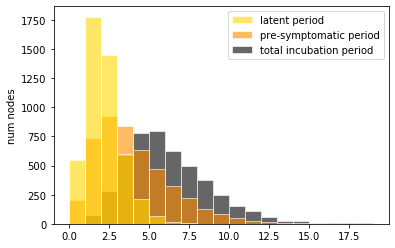

In [74]:
latentPeriod_mean, latentPeriod_coeffvar = 4.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, n_pop)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, n_pop)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

pre-symptomatic period:  mean = 2.17, std = 1.09, 95% CI = (0.56, 4.84)

(a)symptomatic period:  mean = 4.04, std = 1.64, 95% CI = (1.49, 7.94)

total infectious period:  mean = 6.21, std = 1.96, 95% CI = (3.00, 10.70)



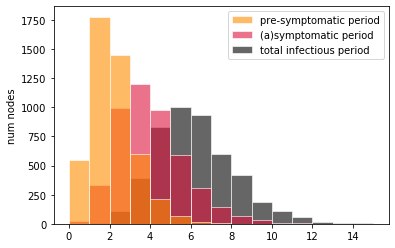

In [75]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, n_pop)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 11.12, std = 5.03, 95% CI = (3.54, 22.79)

hospitalization-to-discharge period:  mean = 7.96, std = 3.55, 95% CI = (2.50, 16.37)

onset-to-discharge period:  mean = 19.07, std = 6.14, 95% CI = (8.99, 33.00)



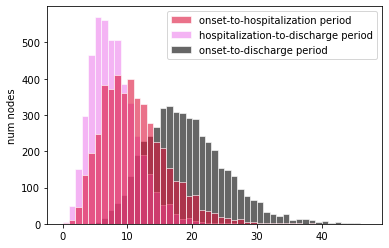

In [76]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, n_pop)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 8.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, n_pop)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 11.12, std = 5.03, 95% CI = (3.54, 22.79)

hospitalization-to-death period:  mean = 10.01, std = 4.40, 95% CI = (3.29, 20.29)

onset-to-death period:  mean = 21.13, std = 6.61, 95% CI = (10.11, 35.74)



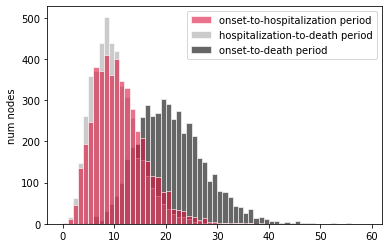

In [77]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 10.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, n_pop)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

In [78]:
ageGroup_pctAsymp = {'0-9':0.6,
                            '10-19':    0.75,
                            '20-29':    0.63,
                            '30-39':    0.58,
                            '40-49':    0.49,
                            '50-59':    0.41,
                            '60-69':    0.28,
                            '70+':    0.24}
PCT_ASYMPTOMATIC = get_values_per_node(ageGroup_pctAsymp, sampled_graph)
len(PCT_ASYMPTOMATIC)

4675

In [79]:
ageGroup_pctHospitalized = {'0-9':      0.0076,
                            '10-19':    0.0081,
                            '20-29':    0.0099,
                            '30-39':    0.0185,
                            '40-49':    0.0543,
                            '50-59':    0.1505,
                            '60-69':    0.3329,
                            '70+':    0.6176}
PCT_HOSPITALIZED = get_values_per_node(ageGroup_pctHospitalized, sampled_graph)
len(PCT_HOSPITALIZED)

4675

In [80]:
ageGroup_hospitalFatalityRate = {'0-9':     0.0000,
                                 '10-19':   0.3627,
                                 '20-29':   0.0577,
                                 '30-39':   0.0426,
                                 '40-49':   0.0694,
                                 '50-59':   0.1532,
                                 '60-69':   0.3381,
                                 '70-79':   0.5187,
                                 '80+':     0.7283 }

PCT_FATALITY = get_values_per_node(ageGroup_hospitalFatalityRate, sampled_graph)
len(PCT_FATALITY)

4675

Individual R0:  mean = 2.49, std = 0.50, 95% CI = (1.64, 3.57)



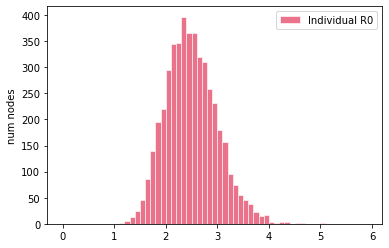

In [81]:
R0_mean     = 2.5
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, n_pop)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

In [82]:
BETA = 1/infectiousPeriod * R0

In [83]:
BETA_Q = BETA * (0.3/R0_mean)

In [84]:
BETA_PAIRWISE_MODE  = 'infected'

In [85]:
DELTA_PAIRWISE_MODE = 'mean'

In [86]:
ageGroup_susceptibility = {"0+": 1.0}
ALPHA = get_values_per_node(ageGroup_susceptibility, sampled_graph)
len(ALPHA)

4675

In [87]:
P_GLOBALINTXN = 0.8
Q_GLOBALINTXN = 0.2
INIT_EXPOSED = int(n_pop*0.01)

### 4.1 Set Testing, Tracing, & Isolation (TTI) intervention protocol parameters:

This portion of the notebook is directly taken from the seirsplus repo. It serves as a guide to experiment with parameters

In [88]:
INTERVENTION_START_PCT_INFECTED = 1/100
AVERAGE_INTRODUCTIONS_PER_DAY   = 0

TESTING_CADENCE                 = 'everyday'    # how often to do tracing testing and random testing
PCT_TESTED_PER_DAY              = 0.001          # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 1.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 1.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.25           # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 2             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 2             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating

In [89]:
TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.5
TESTING_COMPLIANCE_RATE_TRACED                       = 1.0
TESTING_COMPLIANCE_RATE_RANDOM                       = 0.8

TRACING_COMPLIANCE_RATE                              = 0.8

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.3
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 0.0

Now, we randomly assign a True/False compliance to each individual according to the rates set above. Individuals whose compliance is set to True for a given intervention will participate in that intervention, individuals set to False will not.

In [90]:
TESTING_COMPLIANCE_RANDOM                        = (numpy.random.rand(n_pop) < TESTING_COMPLIANCE_RATE_RANDOM)
TESTING_COMPLIANCE_TRACED                        = (numpy.random.rand(n_pop) < TESTING_COMPLIANCE_RATE_TRACED)
TESTING_COMPLIANCE_SYMPTOMATIC                   = (numpy.random.rand(n_pop) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC)

TRACING_COMPLIANCE                               = (numpy.random.rand(n_pop) < TRACING_COMPLIANCE_RATE)

ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = (numpy.random.rand(n_pop) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL)
ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = (numpy.random.rand(n_pop) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = (numpy.random.rand(n_pop) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL)
ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = (numpy.random.rand(n_pop) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = (numpy.random.rand(n_pop) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT)
ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = (numpy.random.rand(n_pop) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE)

In [91]:
G_quarantine = remove_edges_from_graph(sampled_graph, scale=2, edge_label_list=["food", "friendship"], min_num_edges=2)

In [92]:
model = ExtSEIRSNetworkModel(G=sampled_graph, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                              G_Q=G_quarantine, q=0, beta_Q=BETA_Q, isolation_time=14,
                              initE=INIT_EXPOSED)

In [93]:
T = 200

In [94]:
run_tti_sim(model, T, 
            intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
            testing_cadence=TESTING_CADENCE, pct_tested_per_day=PCT_TESTED_PER_DAY, test_falseneg_rate=TEST_FALSENEG_RATE, 
            testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
            testing_compliance_traced=TESTING_COMPLIANCE_TRACED, max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
            testing_compliance_random=TESTING_COMPLIANCE_RANDOM, random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
            tracing_compliance=TRACING_COMPLIANCE, pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, tracing_lag=TRACING_LAG,
            isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
            isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
            isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
            isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, isolation_lag_positive=ISOLATION_LAG_POSITIVE, isolation_groups=updated_nodes_per_struct)

[INTERVENTIONS @ t = 1.01 (56 (1.20%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	4	tested randomly         [+ 0 positive (0.00 %) +]
	4	tested TOTAL            [+ 0 positive (0.00 %) +]
	1 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 2.01 (61 (1.30%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	3	tested randomly         [+ 0 positive (0.00 %) +]
	4	tested TOTAL            [+ 1 positive (25.00 %) +]
	2 will isolate due to symptoms         (0 as groupmates of symptomatic)
	1 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	1 entered isolation
[INTERVEN

(1.0061371447895697, 186.18693189302866)

In [96]:
results_summary(model)

total percent infected: 86.01%
total percent fatality: 0.62%
peak  pct hospitalized: 0.41%


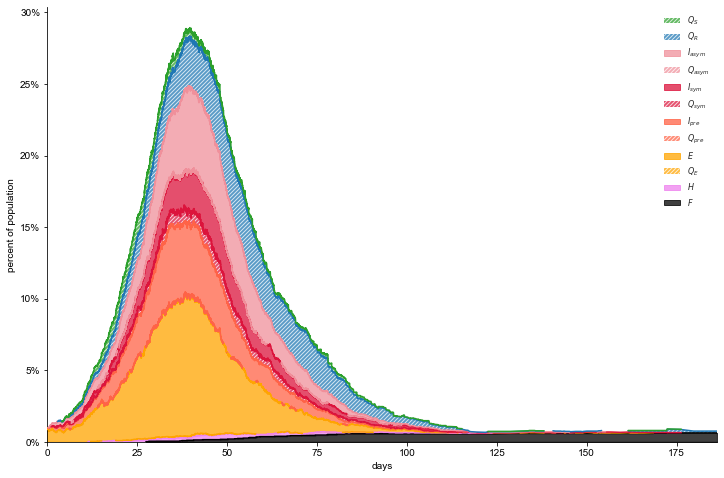

In [97]:
fig, ax = model.figure_infections(combine_Q_infected=False, plot_Q_R='stacked', plot_Q_S='stacked')

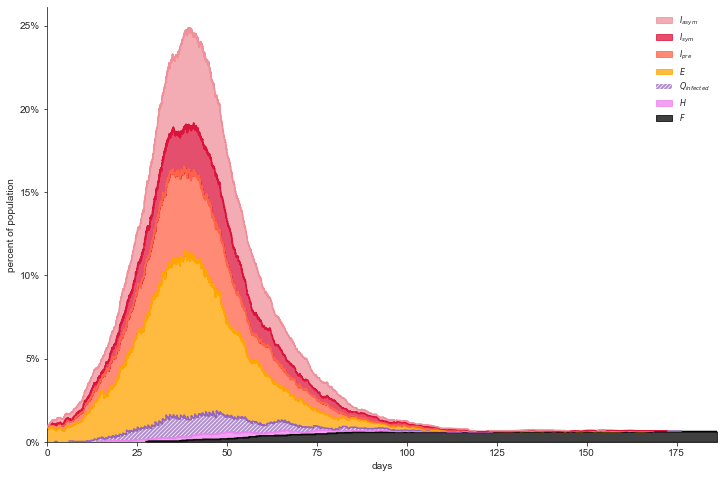

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fad71372ed0>)

In [98]:
model.figure_infections()

In [33]:
import time
import datetime

In [34]:
new_model = ExtSEIRSNetworkModel(G=sampled_graph, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                              initE=INIT_EXPOSED)

In [35]:
# 8700: 3 minutes, 19 seconds
# 6234: 1 minute, 37 seconds
t_steps = 200

start = time.time()
node_states, simulation_results = run_simulation(new_model, t_steps)
stop = time.time()
time_elapsed = stop - start

str(datetime.timedelta(seconds=time_elapsed))

Running simulation for 200 steps...

-------------------------------------------
Day = 0.01
	 Susceptible    = 4629.0
	 Exposed        = 45.0
	 Infected_pre   = 1.0
	 Infected_sym   = 0.0
	 Infected_asym  = 0.0
	 Hospitalized   = 0.0
	 Recovered      = 0.0
	 Fatalities     = 0.0
-------------------------------------------
Day = 30.00
	 Susceptible    = 2671.0
	 Exposed        = 540.0
	 Infected_pre   = 248.0
	 Infected_sym   = 143.0
	 Infected_asym  = 223.0
	 Hospitalized   = 9.0
	 Recovered      = 841.0
	 Fatalities     = 0.0
-------------------------------------------
Day = 60.02
	 Susceptible    = 589.0
	 Exposed        = 117.0
	 Infected_pre   = 65.0
	 Infected_sym   = 97.0
	 Infected_asym  = 95.0
	 Hospitalized   = 17.0
	 Recovered      = 3685.0
	 Fatalities     = 10.0
-------------------------------------------
Day = 90.05
	 Susceptible    = 459.0
	 Exposed        = 10.0
	 Infected_pre   = 7.0
	 Infected_sym   = 9.0
	 Infected_asym  = 9.0
	 Hospitalized   = 4.0
	 Recovered      =

'0:00:59.039170'

In [ ]:
node_states, simulation_results = run_simulation(new_model, t_steps)

In [39]:
import joblib
from joblib import Parallel, delayed

In [44]:
number_of_cpu = joblib.cpu_count()
delayed_funcs = [delayed(run_simulation)(new_model, 200) for _ in range(10)]
parallel_pool = Parallel(n_jobs=number_of_cpu)

In [46]:
%time parallel_pool(1, 200)

TypeError: __call__() takes 2 positional arguments but 3 were given

In [102]:
# Model name for storage + store the model params in csv
i = 0  # This is a number assigned to identify a particular network
param_combo_i = 99  # This is a number assigned to identify a particular combination of parameters
fig_name = f"BaseSympModel{i}_{param_combo_i}"
# add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, BETA, GAMMA, LAMBDA, PCT_HOSPITALIZED, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
# Construct results dataframe
output_df = results_to_df(simulation_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [103]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,T_index,Time
0,8613.0,86.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1
1,8606.0,66.0,22.0,2.0,4.0,0.0,0.0,0.0,41,2
2,8592.0,65.0,32.0,4.0,6.0,0.0,1.0,0.0,76,3
3,8575.0,64.0,39.0,8.0,10.0,0.0,4.0,0.0,125,4
4,8558.0,58.0,47.0,12.0,15.0,0.0,10.0,0.0,186,5
...,...,...,...,...,...,...,...,...,...,...
133,790.0,0.0,0.0,1.0,0.0,2.0,7860.0,47.0,31743,134
134,790.0,0.0,0.0,1.0,0.0,1.0,7861.0,47.0,31744,135
135,790.0,0.0,0.0,0.0,0.0,2.0,7861.0,47.0,31745,136
136,790.0,0.0,0.0,0.0,0.0,1.0,7862.0,47.0,31746,137


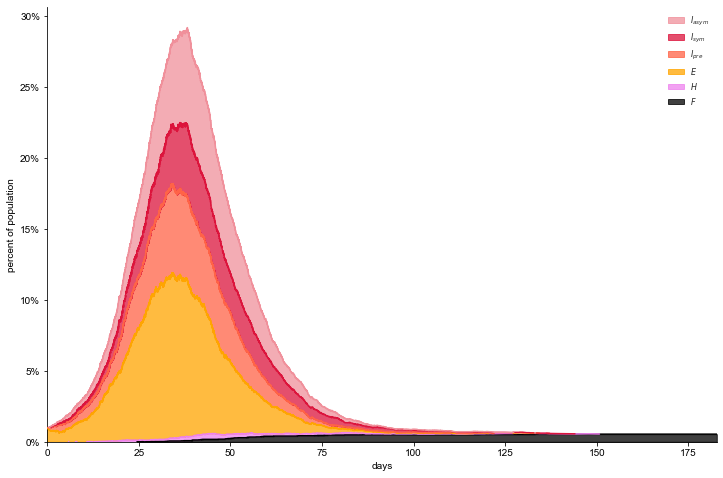

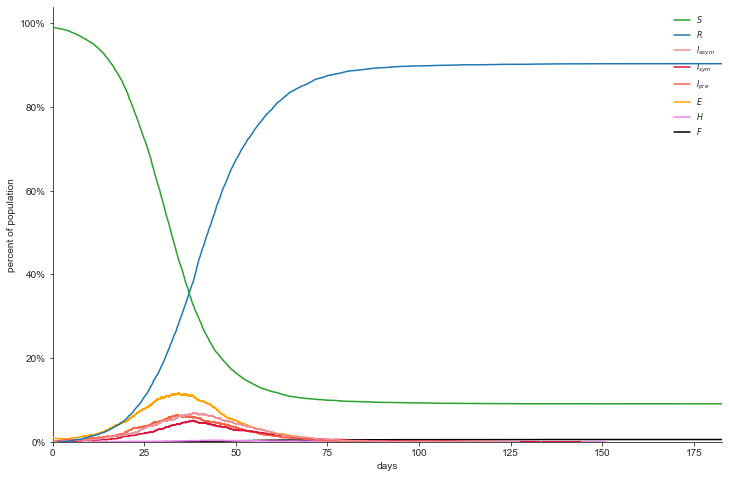

31747

In [104]:
new_model.figure_infections()
new_model.figure_basic()
new_model.tidx

### 5) Running the base model

In [ ]:
# Model construction
ref_model = ExtSEIRSNetworkModel(G=graph_1fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
node_states, simulation_results = run_simulation(ref_model, t_steps)

In [ ]:
sim = pd.DataFrame(simulation_results)
sim

In [ ]:
# Model name for storage + store the model params in csv
i = 0  # This is a number assigned to identify a particular network
param_combo_i = 0  # This is a number assigned to identify a particular combination of parameters
fig_name = f"BaseSympModel{i}_{param_combo_i}"
add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)

In [ ]:
#here we set up a parallel computing to run experiments in parallel and aggregate the results

In [ ]:
# Construct results dataframe
output_df = results_to_df(simulation_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

### 6) Define Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

#### 6.1) First, define the intervention graphs

In [ ]:
# This is social distancing within the food queue 
distancing_graph = remove_edges_from_graph(graph_1fq, scale=10, edge_label_list=["food"], min_num_edges=4)

# This also includes neighbor/friendship edges
quarantine_graph = remove_edges_from_graph(graph_1fq, scale=2, edge_label_list=["food", "friendship"], min_num_edges=2)

# Create graphs with multiple sectoring of food queues - in this case, 1 and 2 queues per each block (4 and 8 food queues respectively)
graph_4fq = create_multiple_food_queues(graph, 1, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])
graph_8fq = create_multiple_food_queues(graph, 2, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])

# Create quarantine graphs for the sectored graphs
quarantine_graph_4fq = remove_edges_from_graph(graph_4fq, scale=2, edge_label_list=[f"food_{i}" for i in range(4)] + ["friendship"], min_num_edges=2)
quarantine_graph_8fq = remove_edges_from_graph(graph_8fq, scale=2, edge_label_list=[f"food_{i}" for i in range(8)] + ["friendship"], min_num_edges=2)

In [ ]:
min_D, max_D = min_degree(distancing_graph), max_degree(distancing_graph)
print("Min degree:", min_D, "Max degree:", max_D)

# As we can see, there isn't much of a difference when we only cut food-queue interactions, 
# which means we need a harder distancing policy
plot_degree_distn(distancing_graph, max_degree=max_D)

In [ ]:
min_Q, max_Q = min_degree(quarantine_graph), max_degree(quarantine_graph)
print("Min degree:", min_Q, "Max degree:", max_Q)

plot_degree_distn(quarantine_graph, max_degree=max_Q)

In [ ]:
# 4 food queues 
min_4fq, max_4fq = min_degree(graph_4fq), max_degree(graph_4fq)
print("Min degree:", min_4fq, "Max degree:", max_4fq)

plot_degree_distn(quarantine_graph, max_degree=max_4fq)

In [ ]:
# 8 food queues
min_8fq, max_8fq = min_degree(graph_8fq), max_degree(graph_8fq)
print("Min degree:", min_8fq, "Max degree:", max_8fq)

plot_degree_distn(quarantine_graph, max_degree=max_8fq)

#### 6.2) Construct the checkpoints

In [ ]:
interventions = Interventions()
reduction_percentage = 0.5

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_1fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_1fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

### 7) Running the model with interventions

In [ ]:
# Model construction with interventions on the model with 1 food queue
interventions_model = ExtSEIRSNetworkModel(G=graph_1fq, Q=quarantine_graph, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
intervention_node_states, intervention_results = run_simulation(interventions_model, t_steps, checkpoints)

In [ ]:
# Model name for storage + store the model params in csv
i, param_combo_i = 0, 0
fig_name = f"InterventionsBaseModel{i}_{param_combo_i}"
add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")


In [ ]:
output_df = results_to_df(intervention_results, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = interventions_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.1) Running the base model with multiple food queues

In [ ]:
# Model construction for multiple food queues but no more interventions
model_4fq = ExtSEIRSNetworkModel(G=graph_4fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

model_8fq = ExtSEIRSNetworkModel(G=graph_8fq, p=prob_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
t_steps = 200
node_states, simulation_results_4fq = run_simulation(model_4fq, t_steps)

In [ ]:
# Model name for storage
food_queue_number = 4
i = 0
fig_name = f"MultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
			

In [ ]:
output_df = results_to_df(simulation_results_4fq, store=True, store_name=f"experiments/results/{fig_name}.csv")


In [ ]:
output_df

In [ ]:
fig, ax = model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
t_steps = 200
node_states, simulation_results_8fq = run_simulation(model_8fq, t_steps)

In [ ]:
food_queue_number = 8
i = 0
fig_name = f"MultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps)
	

In [ ]:
output_df = results_to_df(simulation_results_8fq, store=True, store_name=f"experiments/results/{fig_name}.csv")


In [ ]:
output_df

In [ ]:
fig, ax = model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.2) Running the multiple food queues model with interventions

In [ ]:
# Model construction for multiple food queues in addition to other interventions
interventions_model_4fq = ExtSEIRSNetworkModel(G=graph_4fq, Q=quarantine_graph_4fq, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

interventions_model_8fq = ExtSEIRSNetworkModel(G=graph_8fq, Q=quarantine_graph_8fq, p=prob_global_contact, q=prob_quarantine_global_contact, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, a=prob_asymptomatic, f=death_rate, h=prob_symp_to_hosp, initI_sym=init_symp_cases, initI_asym=init_asymp_cases, store_Xseries=True)

In [ ]:
## Interventions for graph with 4 food queues 
interventions.clear()

# Amount by which wearing masks reduces the transmission rate
reduction_percentage = 0.3

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph_4fq, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_4fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_4fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [ ]:
t_steps = 200
node_states, intervention_results_4fq = run_simulation(interventions_model_4fq, t_steps)

In [ ]:
# Model name for storage - adjust accordingly to interventions
i = 0
food_queue_number = 4
fig_name = f"InterventionsMultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")


In [ ]:
output_df = results_to_df(intervention_results_4fq, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = interventions_model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
# fig.savefig(f"plots/{fig_name}_figBasic.png")

In [ ]:
## Interventions for graph with 8 food queues 
interventions.clear()

# Amount by which wearing masks reduces the transmission rate
reduction_percentage = 0.3

# Simulate quarantine + masks
q_start = 0
interventions.add(quarantine_graph_8fq, q_start, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
q_end = 150
interventions.add(graph_8fq, q_end, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
m_end = 200
interventions.add(graph_8fq, m_end, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [ ]:
t_steps = 200
node_states, interventions_results_8fq = run_simulation(interventions_model_8fq, t_steps)

In [ ]:
i = 0
food_queue_number = 8
fig_name = f"InterventionsMultFQ{food_queue_number}_Model{i}"

add_model_name("experiments/model_names.csv", fig_name, household_weight, neighbor_weight, food_weight, transmission_rate, recovery_rate, progression_rate, hosp_rate, round(sum(crit_rate)/len(crit_rate), 3), death_rate, init_symp_cases, init_asymp_cases, t_steps, f"{q_start}-{q_end}", reduction_percentage, f"{q_start}-{m_end}")

In [ ]:
output_df = results_to_df(intervention_results_8fq, store=True, store_name=f"experiments/results/{fig_name}.csv")

In [ ]:
output_df

In [ ]:
fig, ax = interventions_model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")